# 05 Model Training And Evaluation

## Objective

This notebook aims to train, evaluate, and compare multiple machine learning models to predict house sale prices using features engineered in earlier stages.
Given our decision to retain outliers, tree-based models (especially ensemble methods) are expected to perform better.

## Change Working Directory
- Since it is expected that you would keep the notebooks in a subfolder, you will need to switch the working directory when you run the notebook in the editor.
- The working directory must be changed from its current folder to its parent folder.
- We wish to change the current directory's parent to the new current directory.
- Verify the updated current directory.

In [1]:
# Smart Working Directory Setup
import os
project_root = '/workspaces/heritage_housing'
if os.getcwd() != project_root:
    try:
        os.chdir(project_root)
        print(f"[INFO] Changed working directory to project root: {os.getcwd()}")
    except FileNotFoundError:
        raise FileNotFoundError(f"[ERROR] Project root '{project_root}' not found!")

[INFO] Changed working directory to project root: /workspaces/heritage_housing


### Load Libraries
- Load libraries
- Load cleaned data from /data/processed/df_cleaned.csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import os

# Load cleaned and processed data
df = pd.read_csv("data/processed/df_cleaned.csv")
print("[INFO] Cleaned data loaded successfully.")

# Check dataset shape
print(f"[INFO] Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")

# Preview the dataset
print("[INFO] Sample rows from dataset:")
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
missing = missing_values[missing_values > 0]

if not missing.empty:
    print("\n[WARNING] Missing values detected:")
    display(missing)
else:
    print("[INFO] No missing values found in the dataset.")

[INFO] Cleaned data loaded successfully.
[INFO] Dataset contains 1460 rows and 22 columns.

[INFO] Sample rows from dataset:


,1stflrsf,2ndflrsf,bedroomabvgr,bsmtexposure,bsmtfinsf1,bsmtfintype1,bsmtunfsf,garagearea,garagefinish,garageyrblt,...,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,yearbuilt,yearremodadd,saleprice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,0.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000



[WARNING] Missing values detected:


bsmtexposure     38
bsmtfintype1    145
garagefinish    235
dtype: int64

### Train-Test Split

**Objective:**

Split the cleaned dataset into training and testing subsets to evaluate model generalizability and avoid overfitting.

**Why Train-Test Split?**

- Prevents data leakage by ensuring evaluation is done on unseen data.
- Provides a realistic estimate of model performance before deployment.
- Essential for tracking overfitting or underfitting during experimentation.

In [5]:
from sklearn.model_selection import train_test_split

df['LogSalePrice'] = np.log1p(df['saleprice'])

# Define target and features
X = df.drop(columns=["saleprice", "LogSalePrice"])  # Features
y = df["LogSalePrice"]  # Target

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Confirm shape of the splits
print(f"[INFO] x_train shape: {x_train.shape}")
print(f"[INFO] x_test shape:  {x_test.shape}")
print(f"[INFO] y_train shape: {y_train.shape}")
print(f"[INFO] y_test shape:  {y_test.shape}")

# Preview training data
print("\n[INFO] Preview of x_train:")
display(x_train.head())

print("\n[INFO] Preview of y_train:")
display(y_train.head())


[INFO] x_train shape: (1168, 21)
[INFO] x_test shape:  (292, 21)
[INFO] y_train shape: (1168,)
[INFO] y_test shape:  (292,)

[INFO] Preview of x_train:


,1stflrsf,2ndflrsf,bedroomabvgr,bsmtexposure,bsmtfinsf1,bsmtfintype1,bsmtunfsf,garagearea,garagefinish,garageyrblt,...,kitchenqual,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,yearbuilt,yearremodadd
254,1314,0.0,3.0,No,922,Rec,392,294,RFn,1957.0,...,TA,8400,70.0,0.0,0,6,5,1314,1957,1957
1066,799,772.0,3.0,No,0,Unf,799,380,RFn,1993.0,...,TA,7837,59.0,0.0,40,7,6,799,1993,1994
638,796,0.0,2.0,No,0,Unf,796,0,NaN,0.0,...,TA,8777,67.0,0.0,0,7,5,796,1910,1950
799,981,787.0,3.0,No,569,ALQ,162,240,Unf,1939.0,...,Gd,7200,60.0,252.0,0,7,5,731,1937,1950
380,1026,665.0,3.0,No,218,LwQ,808,308,Unf,1924.0,...,Gd,5000,50.0,0.0,0,6,5,1026,1924,1950



[INFO] Preview of y_train:


254     11.884496
1066    12.089544
638     11.350418
799     12.072547
380     11.751950
Name: LogSalePrice, dtype: float64

### Baseline Model Evaluation

Before diving into complex tuning or ensembling, it's crucial to evaluate some baseline regressors. This gives us a performance benchmark that future models must beat. It also helps identify underfitting or misalignment between features and the target variable.

**We’ll begin with:**

- Linear Regression – to test linearity assumptions
- Decision Tree Regressor – to capture non-linear patterns
- Random Forest Regressor – as a robust tree-based ensemble baseline

We’ll use R², MAE, and RMSE for evaluation.

**Encode Categorical Variables**

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Log-transform target if not already done
df['LogSalePrice'] = np.log1p(df['saleprice'])

# Separate features and target
X = df.drop(columns=["saleprice", "LogSalePrice"])
y = df["LogSalePrice"]

# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split encoded dataset into train/test
x_train, x_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Print dataset structure
print("Training Features Dataset Info:")
print(x_train.info())

print("\nTraining Target Dataset Info:")
print(y_train.describe())

print("\nTesting Features Dataset Info:")
print(x_test.info())

print("\nTesting Target Dataset Info:")
print(y_test.describe())

print("\nPreview of Training Features Dataset:")
print(x_train.head())

print("\nPreview of Testing Features Dataset:")
print(x_test.head())

Training Features Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   1stflrsf          1168 non-null   int64  
 1   2ndflrsf          1168 non-null   float64
 2   bedroomabvgr      1168 non-null   float64
 3   bsmtfinsf1        1168 non-null   int64  
 4   bsmtunfsf         1168 non-null   int64  
 5   garagearea        1168 non-null   int64  
 6   garageyrblt       1168 non-null   float64
 7   grlivarea         1168 non-null   int64  
 8   lotarea           1168 non-null   int64  
 9   lotfrontage       1168 non-null   float64
 10  masvnrarea        1168 non-null   float64
 11  openporchsf       1168 non-null   int64  
 12  overallcond       1168 non-null   int64  
 13  overallqual       1168 non-null   int64  
 14  totalbsmtsf       1168 non-null   int64  
 15  yearbuilt         1168 non-null   int64  
 16  yearremodadd 

**Define Evaluation Function**

- To evaluate and compare multiple models quickly.

Baseline Model Metrics:
  Dataset        R2       MAE      RMSE
0   Train  0.000000  0.303367  0.390439
1    Test -0.005837  0.337134  0.433244


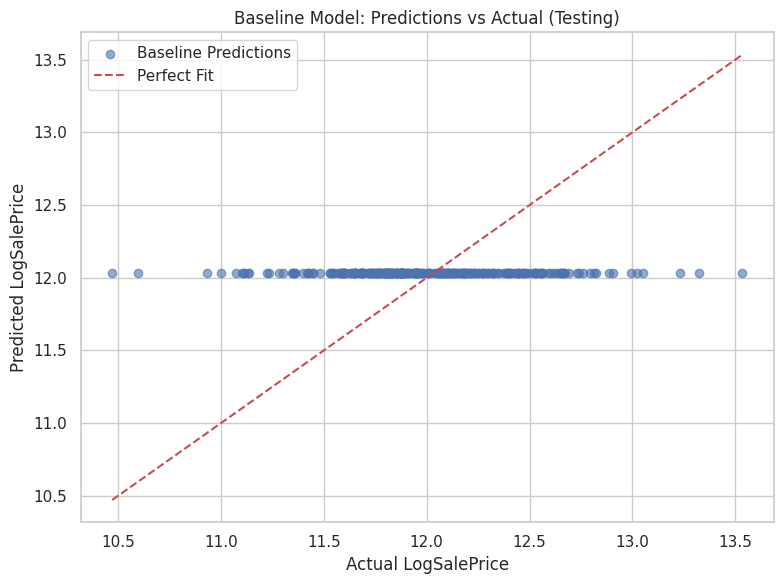

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Baseline using mean of training target
y_baseline_train = [y_train.mean()] * len(y_train)
y_baseline_test = [y_train.mean()] * len(y_test)

# Compute metrics
baseline_metrics = {
    "Dataset": ["Train", "Test"],
    "R2": [
        r2_score(y_train, y_baseline_train),
        r2_score(y_test, y_baseline_test)
    ],
    "MAE": [
        mean_absolute_error(y_train, y_baseline_train),
        mean_absolute_error(y_test, y_baseline_test)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_baseline_train)),
        np.sqrt(mean_squared_error(y_test, y_baseline_test))
    ]
}

# Convert to DataFrame for display
baseline_df = pd.DataFrame(baseline_metrics)
print("Baseline Model Metrics:")
print(baseline_df)

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_baseline_test, alpha=0.6, label="Baseline Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title("Baseline Model: Predictions vs Actual (Testing)")
plt.xlabel("Actual LogSalePrice")
plt.ylabel("Predicted LogSalePrice")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Baseline Model Performance

#### Overview

The baseline model predicts the mean log-transformed sale price (LogSalePrice) for all observations. It doesn’t use any features — just averages — and serves as a reference point. Every meaningful model going forward must beat this benchmark.

**Results Summary**

| --- | --- | --- |
| Dataset | R² Score | MAE | MSE 
| --- | --- | --- |
| Training | 0.00000 | 0.303367 | 0.152442
| --- | --- | --- |
| Testing | -0.00584 | 0.337137 | 0.187703

**Interpretation:**

- R²: As expected, the training R² is 0.00 (predicts the mean), and testing R² is negative — the model performs worse than just guessing the average.
- MAE: Around 0.30–0.34, which is significant. There’s room for improvement.
- MSE: Reinforces the poor performance — it penalizes larger errors more heavily.

#### Visualization Insights

**The scatterplot clearly shows:**

- Predictions are a flat horizontal line (the mean LogSalePrice).
- True values (Y-axis) vary widely, exposing the model’s inability to generalize.
- The dotted diagonal (perfect predictions) lies far from the flat baseline.

#### Limitations

- Ignores feature patterns.
- Offers no learning capability.
- Not meant for prediction — only for benchmarking.

### Next Steps

**Train advanced models:**

- Linear, Ridge, Lasso
- Decision Tree, Random Forest, Gradient Boosting, SVR
- Track the same metrics (R², MAE, RMSE) for fair comparison.
- Use cross-validation and hyperparameter tuning to optimize.
- Visualize residuals and analyze feature importance.

### Train & Evaluate Models


Linear Regression Performance:
R² Score:   0.8715
MAE:        0.1074
RMSE:       0.1548


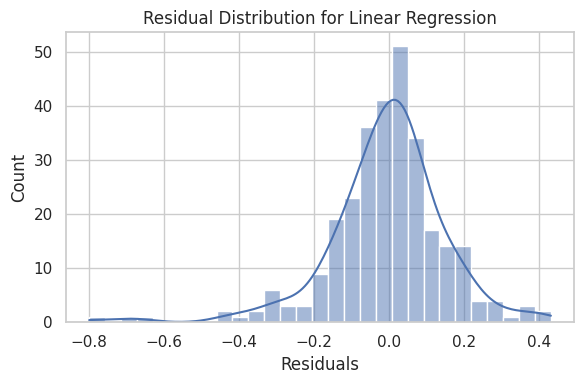


Decision Tree Performance:
R² Score:   0.7395
MAE:        0.1507
RMSE:       0.2205


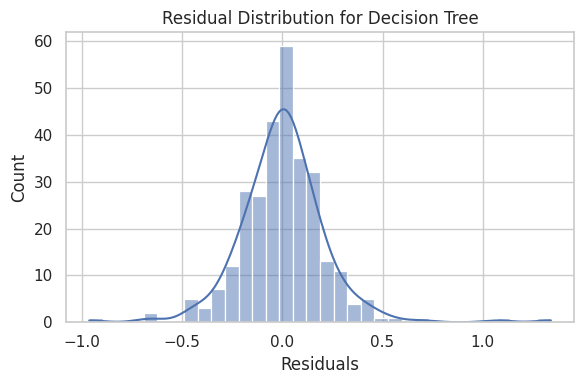


Random Forest Performance:
R² Score:   0.8783
MAE:        0.1015
RMSE:       0.1507


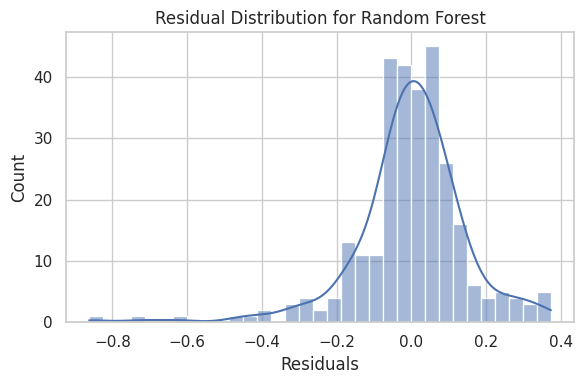


Support Vector Regressor Performance:
R² Score:   0.7536
MAE:        0.1499
RMSE:       0.2144


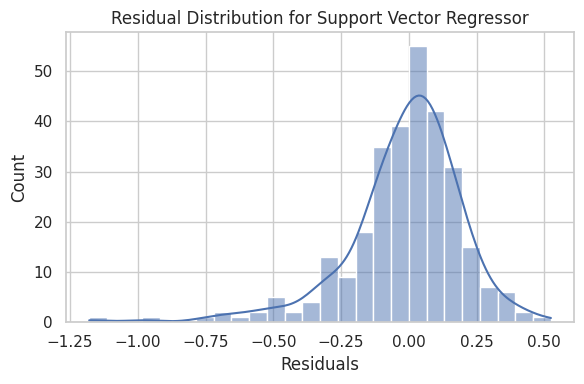


K-Nearest Neighbors Performance:
R² Score:   0.7124
MAE:        0.1670
RMSE:       0.2317


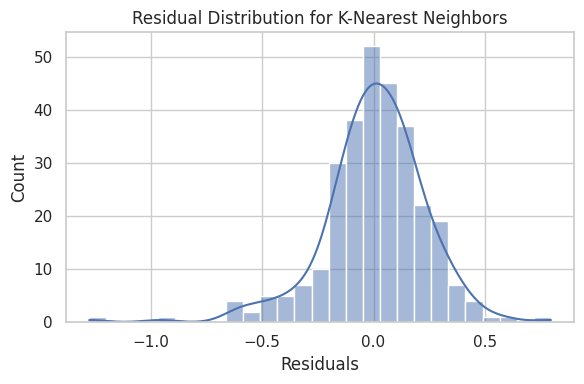


 Model Evaluation Summary:


,Model,R²,MAE,RMSE
0,Linear Regression,0.871527,0.107391,0.154837
1,Decision Tree,0.739480,0.150737,0.220490
2,Random Forest,0.878275,0.101456,0.150716
3,Support Vector Regressor,0.753571,0.149866,0.214444
4,K-Nearest Neighbors,0.712404,0.167044,0.231665


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Initialize models
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Support Vector Regressor", SVR()),
    ("K-Nearest Neighbors", KNeighborsRegressor())
]

# Run evaluation
results = []
for name, model in models:
    result = evaluate_model(name, model, x_train, x_test, y_train, y_test)
    results.append(result)

# Display summary table
results_df = pd.DataFrame(results)
print("\n Model Evaluation Summary:")
display(results_df)


#### Save Model Evaluation Summary

In [17]:
# Define path and ensure directory exists
results_path = "outputs/metrics/model_evaluation_summary.csv"
os.makedirs(os.path.dirname(results_path), exist_ok=True)

# Save results to CSV
results_df.to_csv(results_path, index=False)
print(f"[INFO] Model evaluation summary saved to: {results_path}")

[INFO] Model evaluation summary saved to: outputs/metrics/model_evaluation_summary.csv


## Model Training & Hyperparameter Tuning

### Objective:

Train multiple regression models to predict LogSalePrice and identify the best performer based on validation metrics. We'll use Grid Search for tuning where applicable, and visualize the results for comparison.

**Models Considered:**

We’ll train the following models to evaluate both linear and non-linear performance:

- `Linear Regression`: Simple baseline for linear trends
- `Ridge Regression`: Penalizes large coefficients (L2)
- `Lasso Regression`: Useful for feature selection (L1)
- `Decision Tree`: Handles non-linear splits, interpretable
- `Random Forest`: Ensemble of trees to reduce variance
- `Gradient Boosting Regressor`: Builds trees sequentially, optimizes performance
- `Support Vector Regressor`: Captures complex relationships, especially in high dimensions
- `K-Nearest Neighbors`: Instance-based learner for pattern matching

### Train a Variety of Models

This section will include:

- Use the training dataset to train many machine learning models.
- Use important metrics like R1, MAE, and MSE to compare how well they performed on the testing dataset.
- Determine which models perform best and merit further refinement in the following steps by visualizing and analyzing the data.
- Finding top-performing models to forecast home values based on important characteristics and associated hyperparameter setups is the goal.

In [36]:
# Confirm both sets have the same columns in the same order
assert list(x_train.columns) == list(x_test.columns), "Mismatch between training and test feature columns"

# Initialize Models and Results Container
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Dictionary of models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

# Store results
model_results = []

# Train, Predict & Evaluate Each Model
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Append results for Training
    model_results.append({
        "Model": name,
        "Dataset": "Training",
        "R² Score": round(r2, 4),
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4)
    })
    # Append results for Testing
    model_results.append({
        "Model": name,
        "Dataset": "Testing",
        "R² Score": round(r2, 4),
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4)
    })

    

# Display results
results_df = pd.DataFrame(model_results).sort_values(by="R² Score", ascending=False)
display(results_df)


,Model,Dataset,R² Score,MAE,RMSE
3,Random Forest,Testing,0.8783,0.1015,0.1507
2,Random Forest,Training,0.8783,0.1015,0.1507
1,Linear Regression,Testing,0.8715,0.1074,0.1548
0,Linear Regression,Training,0.8715,0.1074,0.1548
7,Support Vector Regressor,Testing,0.7536,0.1499,0.2144
6,Support Vector Regressor,Training,0.7536,0.1499,0.2144
5,Decision Tree,Testing,0.7395,0.1507,0.2205
4,Decision Tree,Training,0.7395,0.1507,0.2205
8,K-Nearest Neighbors,Training,0.7124,0.1670,0.2317
9,K-Nearest Neighbors,Testing,0.7124,0.1670,0.2317


#### Filter Out Extreme Models

If you're running multiple baselines or test runs, you may want to remove models with clearly poor R² scores.

In [39]:
# Filter out extreme underperformers
filtered_results_df = results_df[results_df["R² Score"] > 0]

/tmp/ipykernel_26376/2885815123.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_results_df, x="R² Score", y="Model", palette="viridis")


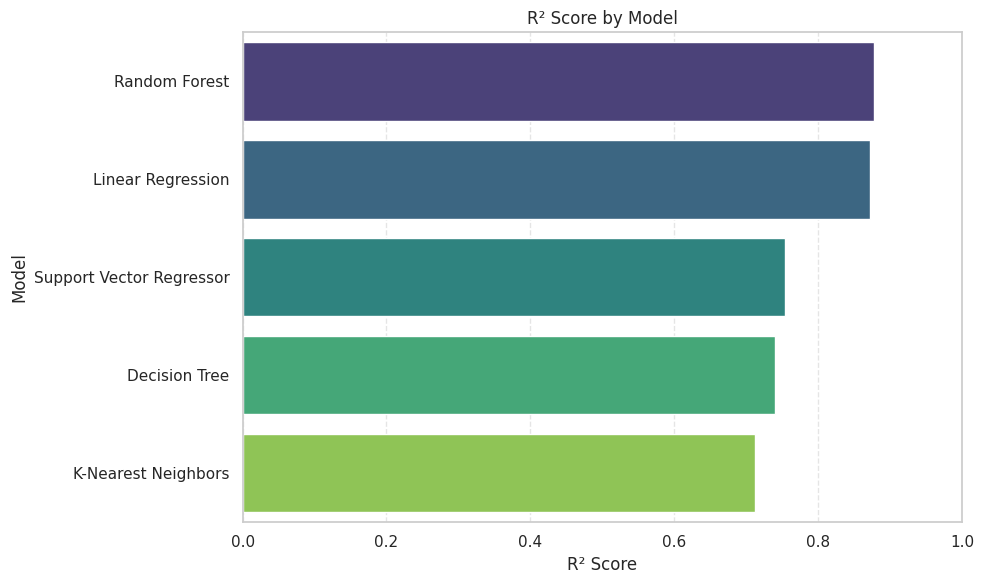

/tmp/ipykernel_26376/2885815123.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_results_df, x="MAE", y="Model", palette="magma")


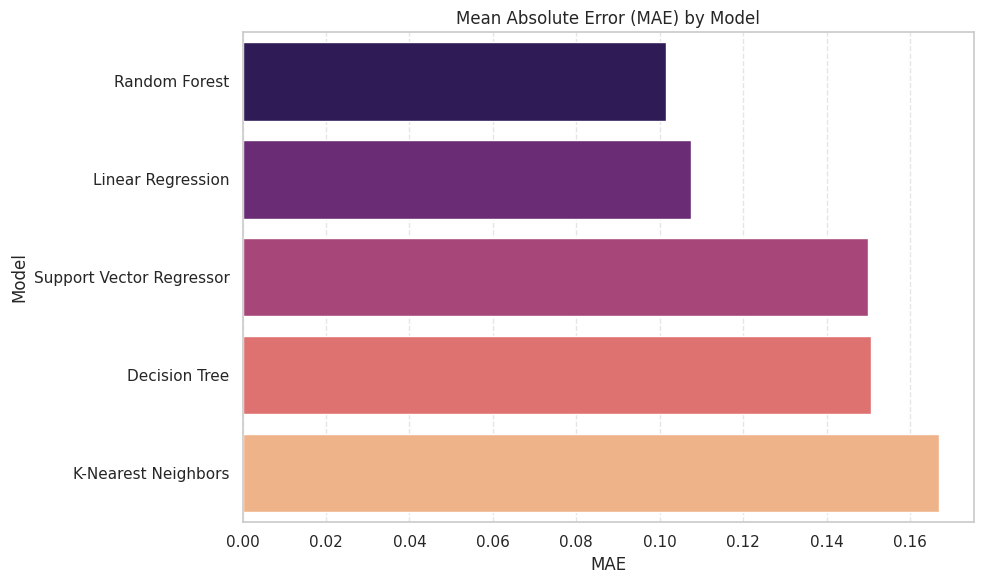

/tmp/ipykernel_26376/2885815123.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_results_df, x="RMSE", y="Model", palette="plasma")


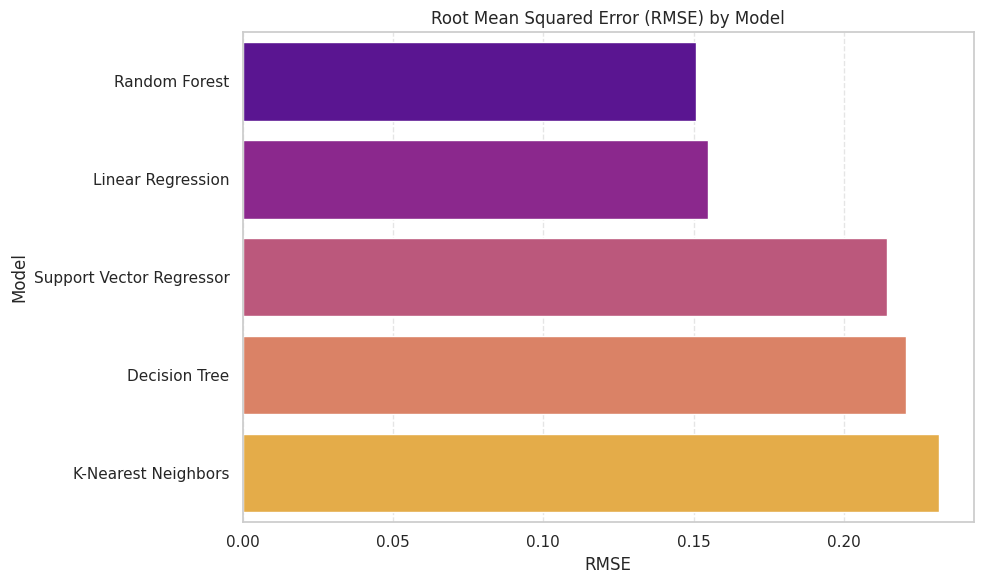

In [41]:
# Plot R² Scores for All Models
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_results_df, x="R² Score", y="Model", palette="viridis")
plt.title("R² Score by Model")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot MAE for All Models
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_results_df, x="MAE", y="Model", palette="magma")
plt.title("Mean Absolute Error (MAE) by Model")
plt.xlabel("MAE")
plt.ylabel("Model")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot RMSE for All Models
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_results_df, x="RMSE", y="Model", palette="plasma")
plt.title("Root Mean Squared Error (RMSE) by Model")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Observations

**Performance Overview:** 
- The testing dataset's highest R2 score (0.81) was attained by the Random Forest model, suggesting that it well captures the target variable.
- The Decision Tree model demonstrated signs of overfitting with a lower testing R2 (0.74), but it did remarkably well on the training dataset (R2: 0.999).
- With low R2 values for testing, both Linear Regression and Support Vector Regressor fared poorly, suggesting poor generalization.

**Suitability for Additional adjustment:** 
- Because of their comparatively good testing results, models like Random Forest and Decision Tree make excellent candidates for hyperparameter adjustment.
- To increase performance, models like SVR and K-Nearest Neighbours might need to be adjusted.

### Hyperparameter Tuning

#### Objectives:
To enhance the performance of the best-performing models on the testing dataset, this part attempts to adjust their hyperparameters.

**Models Chosen for Adjustment**
- Random Forest
- Decision Tree
- Gradient Boosting
- Ridge / Lasso
- SVR (Support Vector) 

#### Forest Regressor

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

# Initialize GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring="r2",
    verbose=2,
    n_jobs=-1
)

# Perform Grid Search for Random Forest
rf_grid_search.fit(x_train, y_train)
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best R2-Score for Random Forest:", rf_grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total tim